## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import mpl_scatter_density as mpl

In [2]:
#import sys
#!{sys.executable} -m pip install mpl_scatter_density

## Reading the data

In [4]:
#read data and shuffle
bhbh = pd.read_csv('../Data/BHBH.csv')
bhbh = bhbh.sample(frac=1, random_state=4269)

#adding q column
bhbh['q'] = np.where(bhbh['Mass_1_out']>bhbh['Mass_0_out'], bhbh['Mass_0_out']/bhbh['Mass_1_out'], bhbh['Mass_1_out']/bhbh['Mass_0_out'] )
bhbh.head()

,Unnamed: 0,name,Mass_0,Z_0,spin_0,SN_0,Tstart_0,Mass_1,Z_1,a,...,Temperature_0,Mass_1_out,Semimajor,Eccentricity,GWtime,BWorldtime,RLO,CE,tdelay,q
60395,209,0_237173268166122,38.986,0.001,0.0,rapid_gauNS,zams,36.603,0.001,36900.0,...,1456.304,35.000250,38613.90000,0.469578,1.467217e+15,5.305830,NaN,NaN,1.467217e+15,0.945802
74427,314,0_619601822689455,53.812,0.010,0.0,rapid_gauNS,zams,45.722,0.010,1840.0,...,2113.531,14.892850,650.26520,0.015402,3.159041e+09,4.467546,2.0,NaN,3.159041e+09,0.847657
19596,182,0_627668720580822,62.816,0.001,0.0,rapid_gauNS,zams,44.208,0.001,9070.0,...,1184.211,41.659050,9848.93600,0.085256,6.046951e+12,4.666363,NaN,NaN,6.046951e+12,0.744376
78838,298,0_956602933765968,32.894,0.010,0.0,rapid_gauNS,zams,24.726,0.010,94.4,...,3023.349,5.982366,67.27397,0.209334,3.494275e+06,6.771645,3.0,NaN,3.494282e+06,0.696746
74567,110,0_435695643683693,76.275,0.001,0.0,rapid_gauNS,zams,60.763,0.001,1090.0,...,1474.168,35.156080,590.51490,0.025411,2.013698e+08,3.814600,2.0,NaN,2.013698e+08,0.973463


## Setting the labels

In [47]:
# Setting the labels

n_bins = 244

bhbh['q_label'] = (bhbh['q']*n_bins).astype('int')
#bhbh['q_label']=(bhbh['q'].round(2)*100).astype('int')

bhbh['q_label'].unique().shape

(221,)

In [48]:
bhbh[bhbh['q']<0.05]

,Unnamed: 0,name,Mass_0,Z_0,spin_0,SN_0,Tstart_0,Mass_1,Z_1,a,...,Mass_1_out,Semimajor,Eccentricity,GWtime,BWorldtime,RLO,CE,tdelay,q,q_label


## Preparing the data for xgboost

In [49]:
#bhbh[bhbh['q'].round(2)>=1]

In [50]:
data = bhbh[['Mass_0', 'Z_0', 'Mass_1', 'Z_1', 'a', 'e']][1:60000]
label = bhbh[['q_label']][1:60000]
dtrain = xgb.DMatrix(data, label=label)

In [51]:
data = bhbh[['Mass_0', 'Z_0', 'Mass_1', 'Z_1', 'a', 'e']][60000:70000]
label = bhbh[['q_label']][60000:70000]
dtest = xgb.DMatrix(data, label=label)

## Boost Parameters

In [52]:
param = {'max_depth': 6, 'eta': 0.3, 'objective': 'multi:softprob'}
#param['nthread'] = 4
param['eval_metric'] = 'auc'
param['num_class']=n_bins
#param['eval_metric'] = ['auc', 'ams@0']

evallist = [(dtrain, 'train'), (dtest, 'eval')]

## Training

In [53]:
param

{'max_depth': 6,
 'eta': 0.3,
 'objective': 'multi:softprob',
 'eval_metric': 'auc',
 'num_class': 244}

In [54]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

/home/zenn/anaconda3/envs/dask/lib/python3.11/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[16:11:47] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[16:11:47] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[0]	train-auc:nan	eval-auc:nan
[16:12:01] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[16:12:01] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[1]	train-auc:nan	eval-auc:nan
[16:12:15] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[16:12:15] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[2]	train-auc:nan	eval-auc:nan
[16:12:28] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[16:12:29] WARNING: ../src/metric/auc.cc:328: Dataset is empty, or contains only positive or negative samples.
[3]	train-auc:nan	e

## Saving the model

In [55]:
bst.save_model('0001.model')

## Loading a saved model

In [56]:
#bst = xgb.Booster({'nthread': 4})  # init model
bst.load_model('0001.model')  # load data

## Predictions of the model

In [57]:
ypred = bst.predict(dtest)

In [58]:
#bst.score(data, label)

In [59]:
prediction = pd.DataFrame(ypred)
a=np.array(prediction)
a.shape

(10000, 244)

In [60]:
example = np.array(prediction)[0,:]
example

array([0.00081008, 0.00081008, 0.00081008, 0.00081008, 0.00081008,
       0.00081008, 0.00081008, 0.00081008, 0.00081008, 0.00081008,
       0.00081008, 0.00081008, 0.00081008, 0.00081008, 0.00081008,
       0.00081008, 0.00082126, 0.00081008, 0.00081008, 0.00081008,
       0.00081008, 0.00081008, 0.00081008, 0.00081008, 0.00082126,
       0.00082126, 0.00081394, 0.00083295, 0.00081008, 0.00083293,
       0.0008101 , 0.00081715, 0.00082238, 0.00081511, 0.00081267,
       0.00082586, 0.00082979, 0.00081573, 0.00084313, 0.00081323,
       0.00082735, 0.00081406, 0.0008201 , 0.00084578, 0.00083285,
       0.00085473, 0.00082907, 0.00085579, 0.00094793, 0.00085856,
       0.00085901, 0.00083614, 0.00082488, 0.000828  , 0.00083979,
       0.00090607, 0.00083388, 0.00087225, 0.00085458, 0.00083709,
       0.00082862, 0.00087448, 0.00083329, 0.00086062, 0.00085375,
       0.00085882, 0.00086588, 0.0008485 , 0.00086899, 0.00085238,
       0.00101737, 0.00088174, 0.00089938, 0.00096964, 0.00086

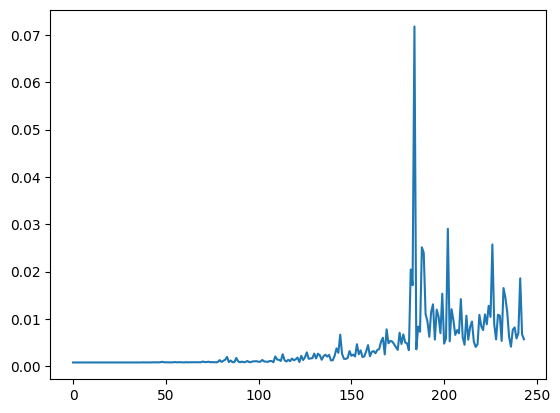

In [61]:
x = np.arange(0, n_bins)
plt.plot(x, example)

In [62]:
bhbh['q_label'][60001]

219

In [63]:
prediction_tot = np.argmax(a, axis=1)
prediction_tot.shape

(10000,)

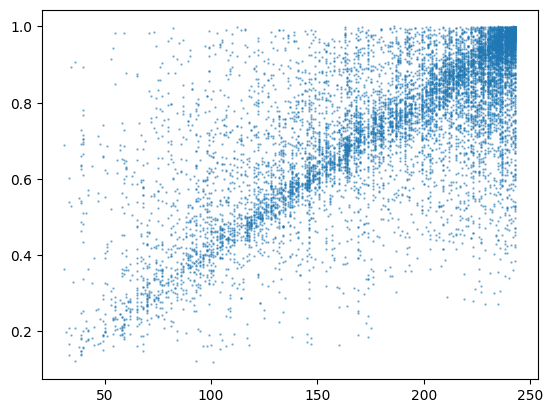

In [64]:
plt.scatter( prediction_tot, bhbh['q'][60000:70000], s=0.5, alpha=0.5)

/home/zenn/anaconda3/envs/dask/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/zenn/anaconda3/envs/dask/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


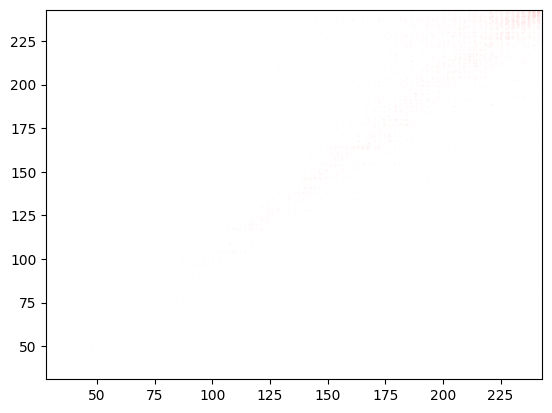

In [65]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1,projection='scatter_density')
ax.scatter_density(bhbh['q_label'][60000:70000], prediction_tot, color='red', vmin=0, vmax=100)

In [ ]:
plt.hist(prediction_tot);
plt.hist(bhbh['q_label'][60000:70000], alpha=0.5);

In [ ]:
plt.hist(bhbh['q'], bins=100, log=True);